In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *
from fastai.widgets import ClassConfusion

In [2]:
data_path = Path('./chest_xray').absolute()
model_path = Path('./model').absolute()

In [3]:
sz = 456
lr = 0.003
bs = 64

In [4]:
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

def valid_func(o):
    return 'test' in str(o)

def label_func(o):
    name = o.name
    if 'virus' in name:
        return 'virus'
    if 'bacteria' in name:
        return 'bacteria'
    return 'normal'

data = (ImageList.from_folder(data_path)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        .transform(get_transforms(), size=sz)
        .databunch(bs=bs)
        .normalize(stats)
        )

data, data.classes

(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Test: None,
 ['bacteria', 'normal', 'virus'])

In [5]:
def xresnet50(pretrained:bool=False, pretrained_fn:str='done.pth'):
    model = models.xresnet50()
    if pretrained:
        state_dict = torch.load(pretrained_fn)
        model.load_state_dict(state_dict['model'])
    return model

def _xresnet_split(m:nn.Module):
    return (m[0][3], m[1])

In [6]:
learn = cnn_learner(data,
                    xresnet50,
                    split_on=_xresnet_split,
                    cut=-4,
                    bn_wd=False,
                    wd=1e-3,
                    metrics=error_rate,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[BnFreeze,
                                  partial(SaveModelCallback, monitor='error_rate', name='best_error')
                                 ],
                    model_dir=model_path,
                   ).to_fp16()

In [7]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.156202,0.716154,0.190705,01:15
1,0.850466,0.688689,0.177885,01:11
2,0.731130,0.647365,0.182692,01:14
3,0.658658,0.654263,0.168269,01:08
4,0.641070,0.662898,0.174679,01:11


Better model found at epoch 0 with error_rate value: 0.19070513546466827.
Better model found at epoch 1 with error_rate value: 0.17788460850715637.
Better model found at epoch 3 with error_rate value: 0.16826923191547394.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


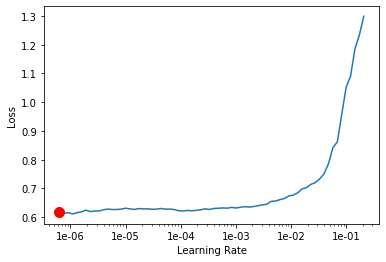

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [9]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr/40, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.622925,0.625389,0.149038,01:13
1,0.620357,0.635475,0.158654,01:12
2,0.608531,0.620360,0.147436,01:16
3,0.608970,0.630661,0.155449,01:13
4,0.611292,0.623007,0.147436,01:13


Better model found at epoch 0 with error_rate value: 0.14903846383094788.
Better model found at epoch 2 with error_rate value: 0.14743590354919434.


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

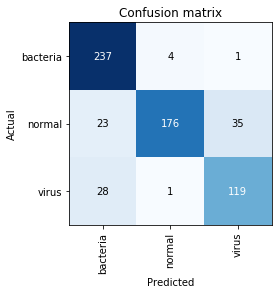

In [11]:
interp.plot_confusion_matrix()

In [12]:
classlist = data.classes
ClassConfusion(interp, classlist, is_ordered=False, figsize=(8,8))

Please enter a value for `k`, or the top images you will see: 5


100%|██████████| 6/6 [01:05<00:00, 10.95s/it]


<Figure size 432x288 with 0 Axes>